In [ ]:
import pandas as pd
import os
import dill
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score,
    balanced_accuracy_score)
import scam_job_detector.ML_logic.preprocessor as pre
print("Imported from:", pre.__file__)
print("Functions available:", dir(pre))
from scam_job_detector.ML_logic.preprocessor import train_preprocessor, test_preprocessor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
%load_ext autoreload
%autoreload 2

Imported from: /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/scam_job_detector/ML_logic/preprocessor.py
Functions available: ['ColumnTransformer', 'FunctionTransformer', 'OneHotEncoder', 'OrdinalEncoder', 'Pipeline', 'SimpleImputer', 'TfidfVectorizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'binary_columns', 'categorical_columns', 'dill', 'make_column_transformer', 'make_pipeline', 'np', 'os', 'pd', 'preprocessing_pipeline', 'test_preprocessor', 'text_columns', 'train_preprocessor', 'train_test_split']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
    # -----------------------------
    # Load cleaned dataset
    # -----------------------------

clean_data_path =  "../raw_data/data_cleaned.csv"

df = pd.read_csv(clean_data_path)
print("✅ Clean data loaded")

✅ Clean data loaded


In [4]:
model_path = "../models/model_logreg.dill"
with open(model_path, "rb") as f:
    model = dill.load(f)
    print("✅ Model loaded")

✅ Model loaded


In [5]:
# -----------------------------
# Train-test split
# -----------------------------
X = df.drop(columns=["fraudulent"])
y = df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("✅ Data split into train and test sets")

✅ Data split into train and test sets


## Assess Feature importance through random permutations

In [31]:
# -----------------------------
# Preprocess once
# -----------------------------
X_train_pp, preprocessor_no_text = train_preprocessor(X_train,text=False)
X_test_pp = test_preprocessor(X_test)

# Convert sparse to dense
X_test_dense = pd.DataFrame(X_test_pp.toarray())  # temporarily ignore column names
X_test_dense.columns = [f"f{i}" for i in range(X_test_dense.shape[1])]

Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


In [32]:
log_pipe = make_pipeline(
    preprocessor_no_text,
    LogisticRegression(max_iter=1000, random_state=42)
)
log_pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
#Permutation importance function


def logistic_regression_permutation_importance(model_path, X_test_dense, y_test, n_repeats=2):
    """
    Runs permutation importance on a trained logistic regression model.

    model_path: path to your saved logreg model (model_logreg.dill)
    X_test_pp: preprocessed test data
    y_test: true labels of the test data
    """

    # Load trained Logistic Regression model
    with open(model_path, "rb") as f:
        model = dill.load(f)

    # Compute permutation importances
    result = permutation_importance(
        log_pipe,
        X_test_dense,
        y_test,
        n_repeats=n_repeats,
        scoring="average_precision",
        n_jobs=-1,
        random_state=42
    )

    # Convert to readable results
    importance_df = pd.DataFrame({
        "feature": X_test_dense.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    return importance_df

In [34]:
# Run permutation importance
importance_df = logistic_regression_permutation_importance(model_path, X_test, y_test, n_repeats=2)
print(importance_df.head(50))

                feature  importance_mean  importance_std
6      has_company_logo         0.233845        0.004621
11             industry         0.216239        0.010431
15              country         0.128461        0.005778
12             function         0.126821        0.009396
8       employment_type         0.039409        0.016222
0                 title         0.000000        0.000000
1       company_profile         0.000000        0.000000
2           description         0.000000        0.000000
3          requirements         0.000000        0.000000
4              benefits         0.000000        0.000000
5         telecommuting         0.000000        0.000000
7         has_questions         0.000000        0.000000
9   required_experience         0.000000        0.000000
10   required_education         0.000000        0.000000
13    department_binary         0.000000        0.000000
14  salary_range_binary         0.000000        0.000000


AttributeError: Rectangle.set() got an unexpected keyword argument 'xlabel'

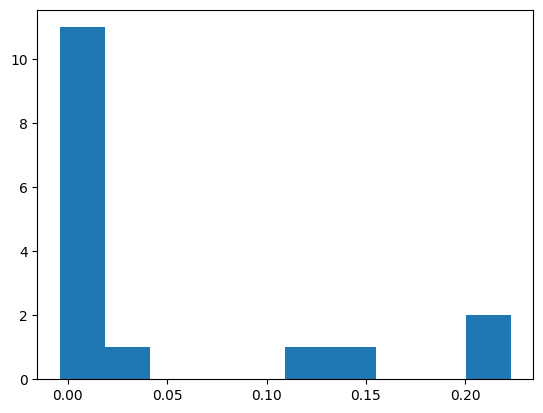

In [47]:
plt.hist(importance_df['importance_mean'].head(20),xlabel='Feature Importance', ylabel='Frequency', title='Top 20 Feature Importances')


In [6]:
#Make new preprocessor with text only
X_train_text_only_pp, preprocessor_text_only = train_preprocessor(X_train, text_only=True)
X_test_text_only_pp = test_preprocessor(X_test)


Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


In [18]:
#fit model with text only preprocessor
xgb_text_only = make_pipeline(
    preprocessor_text_only,
    XGBClassifier(objective="binary:logistic",
                  eval_metric="logloss",
                  n_jobs=-1,
                  random_state=42,
                  learning_rate=0.1,
                  max_depth=11,
                  n_estimators=275,
                  verbose=1
        )
)
results = xgb_text_only.fit(X_train, y_train)

/Users/gillestondeur/.pyenv/versions/3.10.6/envs/scam_job_detector/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [15:24:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
#make xgb teext only predictions on test set and evaluate
y_pred = xgb_text_only.predict(X_test)
y_proba = xgb_text_only.predict_proba(X_test)[:, 1]

print("Accuracy_text_only:", accuracy_score(y_test, y_pred))
print("Precision_text_only:", precision_score(y_test, y_pred))
print("Recall_text_only:", recall_score(y_test, y_pred))
print("F1 Score_text_only:", f1_score(y_test, y_pred))
print("Balanced Accuracy_text_only:", balanced_accuracy_score(y_test, y_pred))

# Metrics that require probabilities
print("Average Precision (AP)_text_only:", average_precision_score(y_test, y_proba))
print("ROC-AUC_text_only:", roc_auc_score(y_test, y_proba))

Accuracy_text_only: 0.9829418344519015
Precision_text_only: 0.9912280701754386
Recall_text_only: 0.653179190751445
F1 Score_text_only: 0.7874564459930313
Balanced Accuracy_text_only: 0.8264426661955873
Average Precision (AP)_text_only: 0.9123521744507596
ROC-AUC_text_only: 0.9890185300627294


In [26]:
X_train_pp, preprocessor = train_preprocessor(X_train,text=True)
X_test_pp = test_preprocessor(X_test)

Preprocessor saved at /Users/gillestondeur/code/syeda-tabassum-rahaman/scam-job-detector/models/preprocessor.dill


In [38]:
#fit XGB with all features
xgb_all_features = make_pipeline(
    preprocessor,
    XGBClassifier(objective="binary:logistic",
                  eval_metric="logloss",
                  n_jobs=-1,
                  random_state=42,
                  learning_rate=0.1,
                  max_depth=11,
                  n_estimators=275
    ))
results_all_features = xgb_all_features.fit(X_train, y_train)
results_all_features

,steps,"[('columntransformer', ...), ('xgbclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [42]:
#make xgb all features predictions on test set and evaluate
y_pred_all_features = xgb_all_features.predict(X_test)
y_proba_all_features = xgb_all_features.predict_proba(X_test)[:, 1]

print(f"Accuracy_all_features: {accuracy_score(y_test, y_pred_all_features)}, Accuracy_text_only: {accuracy_score(y_test, y_pred)}")
print(f"Precision_all_features: {precision_score(y_test, y_pred_all_features)}, Precision_text_only: {precision_score(y_test, y_pred)}")
print(f"Recall_all_features: {recall_score(y_test, y_pred_all_features)}, Recall_text_only: {recall_score(y_test, y_pred)}")
print(f"F1 Score_all_features: {f1_score(y_test, y_pred_all_features)}, F1 Score_text_only: {f1_score(y_test, y_pred)}")
print(f"Balanced Accuracy_all_features: {balanced_accuracy_score(y_test, y_pred_all_features)}, Balanced Accuracy_text_only: {balanced_accuracy_score(y_test, y_pred)}")

# Metrics that require probabilities
print(f"Average Precision (AP)_all_features: {average_precision_score(y_test, y_proba_all_features)}, Average Precision (AP)_text_only: {average_precision_score(y_test, y_proba)}")
print(f"ROC-AUC_all_features: {roc_auc_score(y_test, y_proba_all_features)}, ROC-AUC_text_only: {roc_auc_score(y_test, y_proba)}")

Accuracy_all_features: 0.985738255033557, Accuracy_text_only: 0.9829418344519015
Precision_all_features: 0.9919354838709677, Precision_text_only: 0.9912280701754386
Recall_all_features: 0.7109826589595376, Recall_text_only: 0.653179190751445
F1 Score_all_features: 0.8282828282828283, F1 Score_text_only: 0.7874564459930313
Balanced Accuracy_all_features: 0.8553444002996335, Balanced Accuracy_text_only: 0.8264426661955873
Average Precision (AP)_all_features: 0.9332801576425679, Average Precision (AP)_text_only: 0.9123521744507596
ROC-AUC_all_features: 0.9933584613372424, ROC-AUC_text_only: 0.9890185300627294


## TFIDF Grid search 

In [ ]:
# Define text transformer for text only preprocessor

# def combine_text(X):
    # return X[text_columns].fillna("").agg(" ".join, axis=1)

# make pipeline text transformer

# text_transformer = make_pipeline(
#     FunctionTransformer(combine_text, validate=False),
#     TfidfVectorizer(max_features=5000)
# )
# make pipeling with text transformer and xgb

pipe_TFIDF = Pipeline([
    ('text', preprocessor_text_only),
    ('clf', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        learning_rate=0.1,
        max_depth=11,
        n_estimators=275
    ))
])
# param grid for grid search on TFIDF
param_grid = {
'text__pipeline__tfidfvectorizer__max_features': [3000, 5000, 8000, None],
'text__pipeline__tfidfvectorizer__ngram_range': [(1,1), (1,2)],
'text__pipeline__tfidfvectorizer__min_df': [1, 2, 3],
'text__pipeline__tfidfvectorizer__max_df': [0.8, 0.9, 1.0],
'text__pipeline__tfidfvectorizer__sublinear_tf': [True, False]
}
# Run grid search
search_TFIDF = GridSearchCV(
    pipe_TFIDF,
    param_grid=param_grid,
    scoring='average_precision',
    cv=3,
    n_jobs=-1,
    verbose=2
)
best_TDFIDF= search_TFIDF.fit(X_train, y_train)

print("Best score:", best_TFIDF.best_score_)
print("Best params:", best_TFIDF.best_params_)
print("Best estimator:", best_TFIDF.best_estimator_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


ValueError: Invalid parameter 'tfidfvectorizer' for estimator ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function preprocessing_pipeline.<locals>.combine_text at 0x104e8e5f0>)),
                                                 ('tfidfvectorizer',
                                                  TfidfVectorizer(max_features=5000))]),
                                 ['title', 'company_profile', 'description',
                                  'requirements', 'benefits'])]). Valid parameters are: ['force_int_remainder_cols', 'n_jobs', 'remainder', 'sparse_threshold', 'transformer_weights', 'transformers', 'verbose', 'verbose_feature_names_out'].